# Esercizio8 - Pysam

Prendere in input un file in formato `BAM` che contiene allineamenti al cromosoma X (*reference*) e:

- controllare se sono presenti *paired-end* reads
- determinare le lunghezze degli introni supportati dagli allineamenti del file `BAM`, senza utilizzare il metodo `find_introns()`
- determinare la base della *reference* che ha la massima copertura in termini di reads allineati

### 1) Importare `pysam` e la classe `AlignmentFile`

In [1]:
import pysam

In [2]:
from pysam import AlignmentFile

### 2) Leggere il file `BAM` in input

In [3]:
pysam.index('./sample.bam')

''

In [4]:
bam_file = AlignmentFile('./sample.bam', 'rb')

In [5]:
bam_file

### 3) Controllare se sono presenti *paired-end* reads.

In [6]:
alignment_iter = bam_file.fetch()
alignment_list = list(alignment_iter)

any([alignment.is_paired for alignment in alignment_list])

False

### 4) Determinare le lunghezze degli introni supportati dagli allineamenti nel file `BAM`

a) Ricavare l'insieme delle lunghezze degli introni supportati dalle cigar strings che contengono un'operazione `N` (cioé un inserimento nella reference che corrisponde a un introne).

In [7]:
from collections import defaultdict
introns = defaultdict(int)

for alignment in alignment_list:
    ctuples = alignment.cigartuples
    for ix, cig in enumerate(ctuples):
        if cig[0] == 3:
            offset = 0
            if ix > 0:
                offset = ctuples[ix-1][1]
            intron_start = alignment.reference_start + offset
            intron_end = intron_start + cig[1]
            
            introns[(intron_start, intron_end)] += 1
                

In [8]:
for k in introns:
    print(k, introns[k])

(286891, 286948) 1255
(286980, 287267) 16
(286981, 287268) 18
(287041, 287328) 760
(287041, 289040) 468
(287526, 289040) 707
(289272, 289870) 530
(289272, 290252) 730
(289321, 289630) 3
(289322, 289631) 4
(289323, 289632) 10
(289324, 289633) 7
(289325, 289634) 7
(289326, 289635) 2
(289327, 289636) 4
(289328, 289637) 10
(289329, 289638) 7
(289330, 289639) 7
(289331, 289640) 3
(289332, 289641) 5
(289333, 289642) 13
(289334, 289643) 3
(289335, 289644) 11
(289336, 289645) 6
(289337, 289646) 6
(289339, 289648) 6
(289340, 289649) 10
(289341, 289650) 4
(289342, 289651) 6
(289943, 290252) 459
(290596, 294712) 741
(290596, 294822) 586


### 5) Trovare la base della reference che ha copertura massima

a) Determinare la lista delle colonne di *pileup*.

In [9]:
pileup_iter = bam_file.pileup()

In [10]:
pileup_columns = list(pileup_iter)

In [11]:
pileup_columns[:10]

b) Estrarre le colonna di altezza massima (cioé coperta dal maggior numero di allineamenti).

In [12]:
max_height = max([pileup_col.nsegments for pileup_col in pileup_columns])

In [13]:
max_pileup_col = [pileup_col for pileup_col in pileup_columns if pileup_col.nsegments == max_height][0]

In [14]:
max_pileup_col.nsegments

1469

In [15]:
max_pileup_col.pos

286723

### 6) Disegnare un grafico che mostri posizioni di mappaggio e di refskip nel pileup

In [16]:
covs = []
skips = []

for pileupcolumn in bam_file.pileup(min_base_quality = 0):
    cov = pileupcolumn.nsegments
    skipcount = 0
    for pileupread in pileupcolumn.pileups:
        skipcount += pileupread.is_refskip
    covs.append(cov - skipcount)
    skips.append(skipcount)

<BarContainer object of 11777 artists>

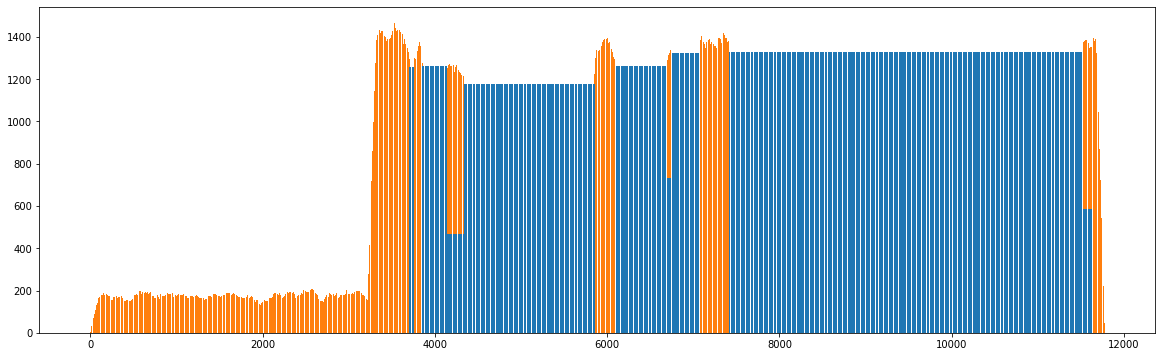

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,6))
plt.bar(range(len(skips)), skips)
plt.bar(range(len(covs)), covs, bottom=skips)